In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
import pandas as pd
models = ['use', 'stf', 'fasttext', 'glove', 'elmo']

model = models[4]

# Load the data
scores_df = pd.read_csv(f'/content/drive/MyDrive/STS Measures/scores/{model}_scores.csv')
model_goals = pd.read_csv(f'/content/drive/MyDrive/STS Measures/scores/{model}_goals.csv')
goals_df = pd.read_csv('/content/drive/MyDrive/STS Measures/scopus_data/gpt_goals.csv')

# # Display the first few rows of each DataFrame
# print(scores_df.head())
# print(goals_df.head())

<ipython-input-40-1a8b61446cc8>:7: DtypeWarning: Columns (9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  scores_df = pd.read_csv(f'/content/drive/MyDrive/STS Measures/scores/{model}_scores.csv')


In [41]:
# Check for missing values
print(scores_df.isnull().sum())
print(goals_df.isnull().sum())

# Fill or drop missing values as needed
scores_df = scores_df.dropna(subset=['Title', 'Abstract'])  # Example: Drop rows where 'Title' or 'Abstract' is missing

# Convert similarity scores to numeric (if not already)
similarity_columns = [col for col in scores_df.columns if 'Goal_' in col]
scores_df[similarity_columns] = scores_df[similarity_columns].apply(pd.to_numeric, errors='coerce')


Authors                             15
Author full names                   15
Author(s) ID                        15
Title                                0
Year                                 0
Source title                         0
Volume                            8916
Issue                            19002
Art. No.                         17066
Page start                        9246
Page end                          9265
Page count                        9152
DOI                               2318
Link                                 0
Abstract                             0
Author Keywords                   5093
Index Keywords                    6381
Document Type                        0
Source                               0
EID                                  0
Abstract Length in Words             0
Abstract Length in Characters        0
Summary                              0
Summary Length in Words              0
Summary Length in Characters         0
Goal_1_Similarity        

In [42]:
average_similarity = (scores_df[similarity_columns].mean()).sort_values(ascending=False)
print(average_similarity)

Goal_12_Similarity    0.694476
Goal_11_Similarity    0.676972
Goal_7_Similarity     0.675992
Goal_9_Similarity     0.669242
Goal_17_Similarity    0.664794
Goal_13_Similarity    0.651830
Goal_6_Similarity     0.650827
Goal_15_Similarity    0.639187
Goal_2_Similarity     0.621967
Goal_14_Similarity    0.619040
Goal_3_Similarity     0.598823
Goal_10_Similarity    0.593735
Goal_16_Similarity    0.588396
Goal_8_Similarity     0.585561
Goal_1_Similarity     0.581097
Goal_4_Similarity     0.573491
Goal_5_Similarity     0.556929
dtype: float64


In [43]:
scores_df['Average_Similarity'] = scores_df[similarity_columns].mean(axis=1)
top_5_papers = scores_df.nlargest(5, 'Average_Similarity')
print(top_5_papers[['Title', 'Average_Similarity']])

                                                   Title  Average_Similarity
20126  Study on the Potential of Virtual Power Plants...            0.817054
16152  Eco-Friendly Geopolymer Concrete: A Critical R...            0.802207
3980   Evaluation of Modern Smart Cities in South Asi...            0.797725
12931  Centering Meaning-Filled Design Within Enginee...            0.796191
18546  Design and Simulation of a Silicon Carbide MOS...            0.795594


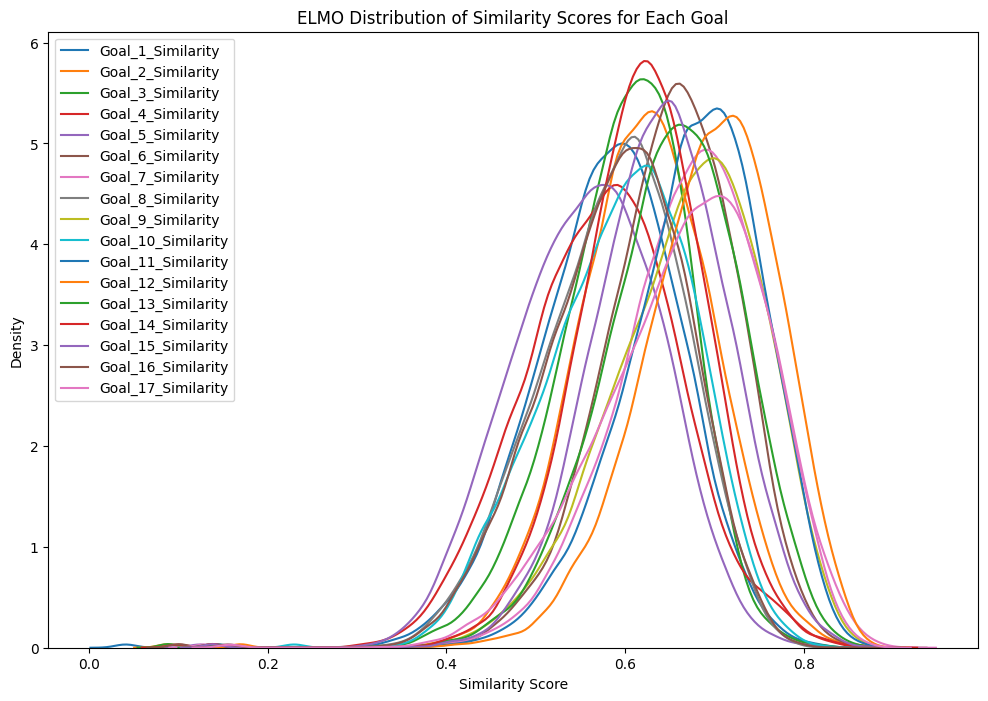

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for col in similarity_columns:
    sns.kdeplot(scores_df[col], label=col)

plt.xlabel('Similarity Score')
plt.ylabel('Density')
plt.title(f'{model.upper()} Distribution of Similarity Scores for Each Goal')
plt.legend()
plt.show()

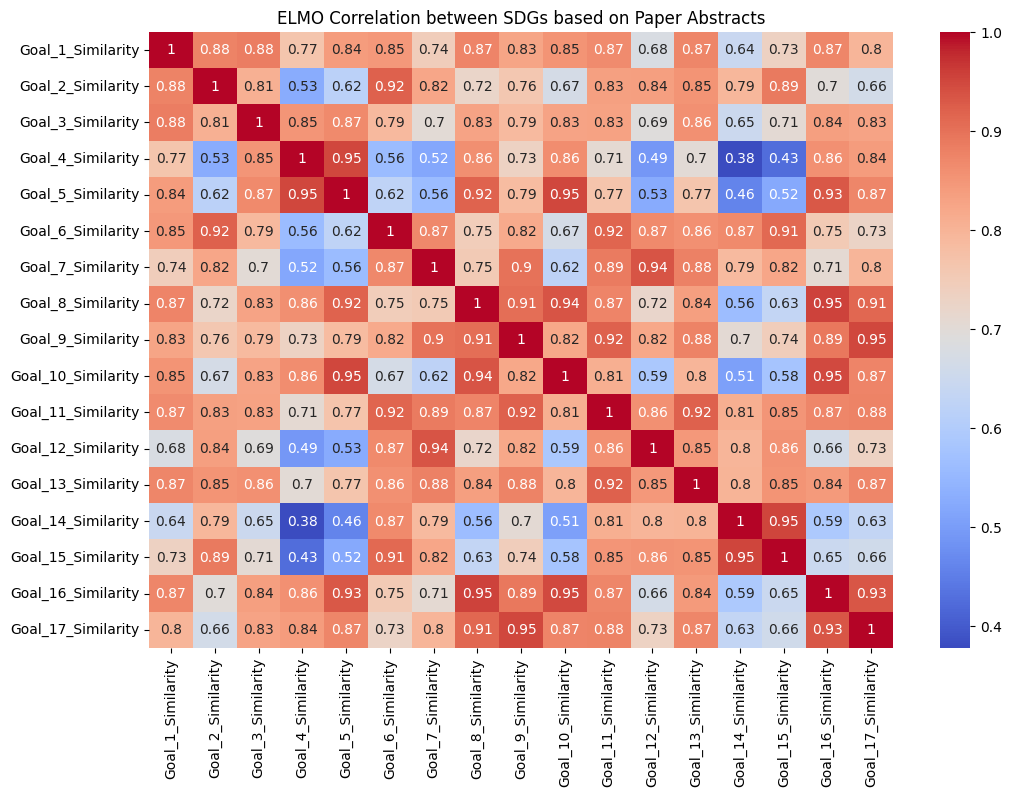

In [45]:
correlation_matrix = scores_df[similarity_columns].corr()
# print(correlation_matrix)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title(f'{model.upper()} Correlation between SDGs based on Paper Abstracts')
plt.show()


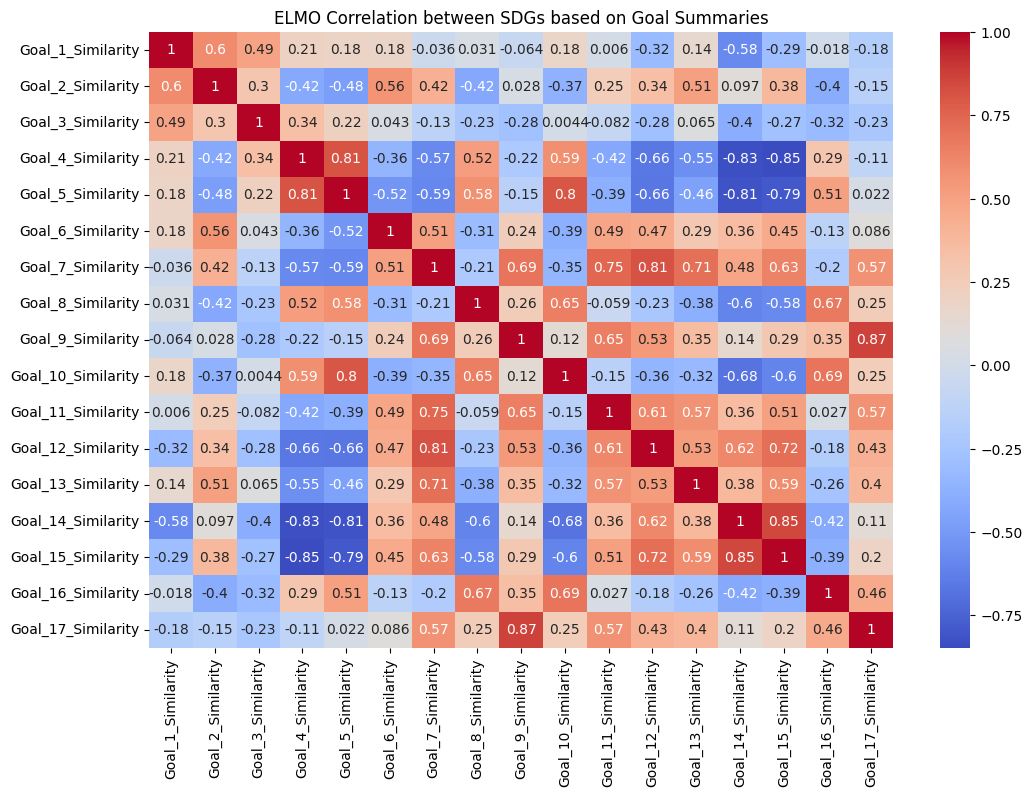

In [46]:
similarity_columns = [col for col in model_goals.columns if col.startswith('Goal_')]

# Compute the correlation matrix
correlation_matrix = model_goals[similarity_columns].corr()

# Display the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title(f'{model.upper()} Correlation between SDGs based on Goal Summaries')
plt.show()

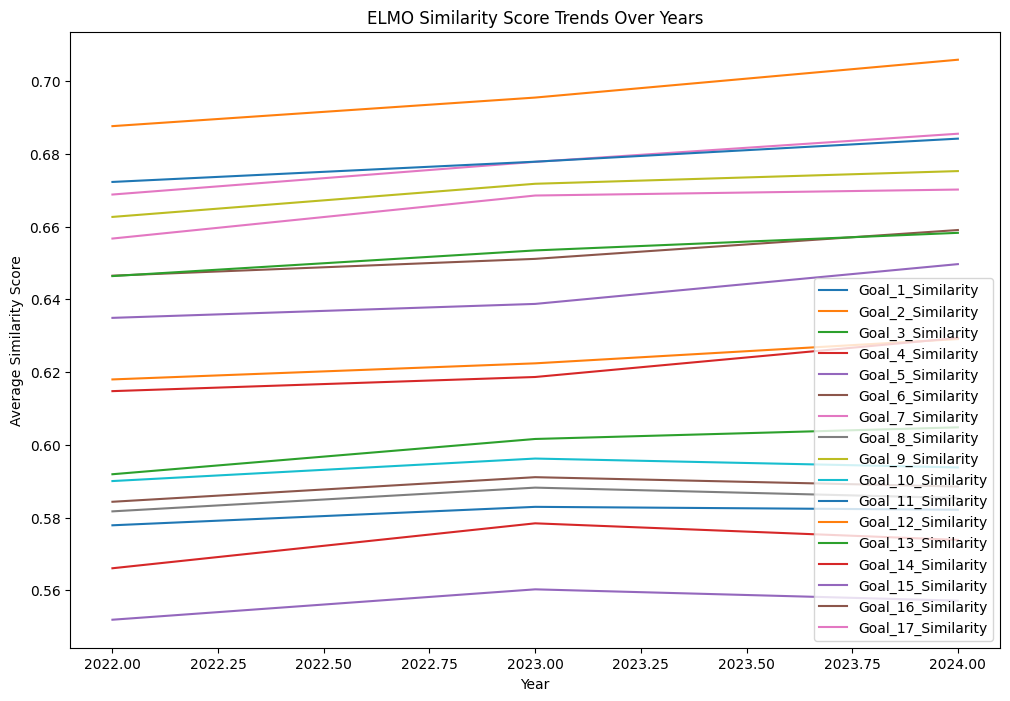

In [47]:
scores_df['Year'] = pd.to_numeric(scores_df['Year'], errors='coerce')
yearly_similarity = scores_df.groupby('Year')[similarity_columns].mean()

plt.figure(figsize=(12, 8))
for col in similarity_columns:
    plt.plot(yearly_similarity.index, yearly_similarity[col], label=col)

plt.xlabel('Year')
plt.ylabel('Average Similarity Score')
plt.title(f'{model.upper()} Similarity Score Trends Over Years')
plt.legend()
plt.show()
